In [3]:
import numpy
from urllib.request import urlopen
import scipy.optimize
from sklearn.decomposition import PCA
import random
from math import exp
from math import log
import matplotlib.pyplot as plt

In [4]:
def parseData(fname):
  for l in urlopen(fname):
    yield eval(l)

In [5]:
print("Reading data...")
data = list(parseData("http://jmcauley.ucsd.edu/cse190/data/beer/beer_50000.json"))
print("done")

Reading data...
done


In [6]:
def feature(datum):
  feat = [1, datum['review/taste'], datum['review/appearance'], datum['review/aroma'], datum['review/palate'], datum['review/overall']]
  return feat

In [7]:
X = [feature(d) for d in data]
y = [d['beer/ABV'] >= 6.5 for d in data]
print(data[0])

{'review/appearance': 2.5, 'beer/style': 'Hefeweizen', 'review/palate': 1.5, 'review/taste': 1.5, 'beer/name': 'Sausa Weizen', 'review/timeUnix': 1234817823, 'beer/ABV': 5.0, 'beer/beerId': '47986', 'beer/brewerId': '10325', 'review/timeStruct': {'isdst': 0, 'mday': 16, 'hour': 20, 'min': 57, 'sec': 3, 'mon': 2, 'year': 2009, 'yday': 47, 'wday': 0}, 'review/overall': 1.5, 'review/text': 'A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.', 'user/profileName': 'stcules', 'review/aroma': 2.0}


In [8]:
def inner(x,y):
  return sum([x[i]*y[i] for i in range(len(x))])

def sigmoid(x):
  return 1.0 / (1 + exp(-x))

In [9]:
##################################################
# Logistic regression by gradient ascent         #
##################################################

In [10]:
# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta)
    loglikelihood -= log(1 + exp(-logit))
    if not y[i]:
      loglikelihood -= logit
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print("ll =" + str(loglikelihood))
  return -loglikelihood

In [11]:
# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      dl[k] += X[i][k] * (1 - sigmoid(logit))
      if not y[i]:
        dl[k] -= X[i][k]
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return numpy.array([-x for x in dl])

In [12]:
X_train, X_validation, X_test = numpy.array_split(X, 3)
y_train, y_validation, y_test = numpy.array_split(y, 3)
print(len(X_train))
print(len(X_test))
print(len(X_validation))

16667
16666
16667


In [13]:
##################################################
# Train                                          #
##################################################
print(X_test[0])
print(y_test[0])

[ 1.  5.  5.  5.  5.  5.]
True


In [14]:
def train(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X_train, y_train, lam))
  return theta

In [15]:
##################################################
# Predict                                        #
##################################################

In [16]:
def performance(theta, X, Y):
  scores = [inner(theta,x) for x in X]
  predictions = [s > 0 for s in scores]
  correct = [(a==b) for (a,b) in zip(predictions,Y)]
  acc = sum(correct) * 1.0 / len(correct)
  return acc

In [17]:
##################################################
# Validation pipeline                            #
##################################################

In [25]:
lam = 1.0

theta = train(lam)
acc_train = performance(theta, X_train, y_train)
print("lambda = " + str(lam) + ":\ttrain accuracy=" + str(acc_train))
acc_validation = performance(theta, X_validation, y_validation)
print("lambda = " + str(lam) + ":\tvalidation accuracy=" + str(acc_validation))
acc_test = performance(theta, X_test, y_test)
print("lambda = " + str(lam) + ":\ttest accuracy=" + str(acc_test))

lambda = 1.0:	train accuracy=0.669946601068
lambda = 1.0:	validation accuracy=0.90076198476
lambda = 1.0:	test accuracy=0.577163086523


In [29]:
def feature1(datum):
  rev = datum['review/text'].lower()
  feat = [1, 'lactic' in rev, 'tart' in rev, 'sour' in rev, 'citric' in rev, 'sweet' in rev, 'acid' in rev, 'hop' in rev,
         'fruit' in rev, 'salt' in rev, 'spicy' in rev]
  return feat

In [31]:
X = [feature1(d) for d in data]
X_train, X_validation, X_test = numpy.array_split(X, 3)

lam = 1.0

theta = train(lam)
acc_train = performance(theta, X_train, y_train)
print("lambda = " + str(lam) + ":\ttrain accuracy=" + str(acc_train))
acc_validation = performance(theta, X_validation, y_validation)
print("lambda = " + str(lam) + ":\tvalidation accuracy=" + str(acc_validation))
acc_test = performance(theta, X_test, y_test)
print("lambda = " + str(lam) + ":\ttest accuracy=" + str(acc_test))


lambda = 1.0:	train accuracy=0.590628187436
lambda = 1.0:	validation accuracy=0.820543589128
lambda = 1.0:	test accuracy=0.476179047162


In [37]:
def performance_detailed(theta, X, Y):
  scores = [inner(theta,x) for x in X]
  predictions = [s > 0 for s in scores]
  TP = sum([(a==b) and a==True for (a,b) in zip(predictions,Y)])
  TN = sum([(a==b) and a==False for (a,b) in zip(predictions, Y)])
  FP = sum([(a!=b) and a==True for (a,b) in zip(predictions, Y)])
  FN = sum([(a!=b) and a==False for (a,b) in zip(predictions, Y)])
  TPR = TP/(TP+FN)
  TNR = TN/(TN+FP)
  BER = 1 - 0.5*(TPR+TNR)
  print("Balanced Error Rate: " + str(BER))
  print("True +ve: " + str(TP))
  print("True -ve: " + str(TN))
  print("False +ve: " + str(FP))
  print("False -ve: " + str(FN))
  print("Total: " + str(len(predictions)))
  print("Sanity check: " + str(TP+TN+FP+FN))

In [38]:
performance_detailed(theta, X_test, y_test)

Balanced Error Rate: 0.439879300591
True +ve: 5018
True -ve: 2918
False +ve: 7837
False -ve: 893
Total: 16666
Sanity check: 16666


In [57]:
# NEGATIVE Log-likelihood for class imbalance
def fc(theta, X, y, lam):
  total = len(y)
  y1count = sum(y)
  y0count = total - sum(y)
  y1balance = total/(2*y1count)
  y0balance = total/(2*y0count)
  #print("Y1, Y0 : " +str(y1count)+","+str(y0count))
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta)
    if(y[i]):
        loglikelihood -= (y1balance*log(1+exp(-logit)))
    elif not y[i]:
        loglikelihood -= (y0balance*(logit + log(1+exp(-logit))))
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print("ll =" + str(loglikelihood))
  return -loglikelihood

In [58]:
# NEGATIVE Derivative of log-likelihood for class imbalance
def fcprime(theta, X, y, lam):
  total = len(y)
  y1count = sum(y)
  y0count = total - sum(y)
  y1balance = total/(2*y1count)
  y0balance = total/(2*y0count)
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      if y[i]:
        dl[k] += (y1balance*(X[i][k] * (1-sigmoid(logit))))
      elif not y[i]:
        dl[k] -= (y0balance*(X[i][k]*sigmoid(logit)))
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return numpy.array([-x for x in dl])

In [59]:
def trainc(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(fc, [0]*len(X[0]), fcprime, pgtol = 10, args = (X_train, y_train, lam))
  return theta

In [60]:
fc(theta, X_train, y_train, lam)

11353.519540437246

In [61]:
lam = 1.0

thetac = trainc(lam)
acc_train = performance(thetac, X_train, y_train)
print("lambda = " + str(lam) + ":\ttrain accuracy=" + str(acc_train))
acc_validation = performance(thetac, X_validation, y_validation)
print("lambda = " + str(lam) + ":\tvalidation accuracy=" + str(acc_validation))
acc_test = performance(thetac, X_test, y_test)
print("lambda = " + str(lam) + ":\ttest accuracy=" + str(acc_test))


lambda = 1.0:	train accuracy=0.569688606228
lambda = 1.0:	validation accuracy=0.476930461391
lambda = 1.0:	test accuracy=0.609324372975


In [62]:
print("Training: ")
performance_detailed(thetac, X_train, y_train)
print("Validation: ")
performance_detailed(thetac, X_validation, y_validation)
print("Test: ")
performance_detailed(thetac, X_test, y_test)

Training: 
Balanced Error Rate: 0.415319661713
True +ve: 4316
True -ve: 5179
False +ve: 2139
False -ve: 5033
Total: 16667
Sanity check: 16667
Validation: 
Balanced Error Rate: 0.37890556133
True +ve: 7358
True -ve: 591
False +ve: 167
False -ve: 8551
Total: 16667
Sanity check: 16667
Test: 
Balanced Error Rate: 0.429410539617
True +ve: 2585
True -ve: 7570
False +ve: 3185
False -ve: 3326
Total: 16666
Sanity check: 16666


In [63]:
lam = 0

thetac = trainc(lam)
acc_train = performance(thetac, X_train, y_train)
print("lambda = " + str(lam) + ":\ttrain accuracy=" + str(acc_train))
acc_validation = performance(thetac, X_validation, y_validation)
print("lambda = " + str(lam) + ":\tvalidation accuracy=" + str(acc_validation))

lam = 0.01

thetac = trainc(lam)
acc_train = performance(thetac, X_train, y_train)
print("lambda = " + str(lam) + ":\ttrain accuracy=" + str(acc_train))
acc_validation = performance(thetac, X_validation, y_validation)
print("lambda = " + str(lam) + ":\tvalidation accuracy=" + str(acc_validation))

lam = 0.1

thetac = trainc(lam)
acc_train = performance(thetac, X_train, y_train)
print("lambda = " + str(lam) + ":\ttrain accuracy=" + str(acc_train))
acc_validation = performance(thetac, X_validation, y_validation)
print("lambda = " + str(lam) + ":\tvalidation accuracy=" + str(acc_validation))

lam = 1.0

thetac = trainc(lam)
acc_train = performance(thetac, X_train, y_train)
print("lambda = " + str(lam) + ":\ttrain accuracy=" + str(acc_train))
acc_validation = performance(thetac, X_validation, y_validation)
print("lambda = " + str(lam) + ":\tvalidation accuracy=" + str(acc_validation))

lam = 100

thetac = trainc(lam)
acc_train = performance(thetac, X_train, y_train)
print("lambda = " + str(lam) + ":\ttrain accuracy=" + str(acc_train))
acc_validation = performance(thetac, X_validation, y_validation)
print("lambda = " + str(lam) + ":\tvalidation accuracy=" + str(acc_validation))

lambda = 0:	train accuracy=0.569688606228
lambda = 0:	validation accuracy=0.476930461391
lambda = 0.01:	train accuracy=0.569688606228
lambda = 0.01:	validation accuracy=0.476930461391
lambda = 0.1:	train accuracy=0.569688606228
lambda = 0.1:	validation accuracy=0.476930461391
lambda = 1.0:	train accuracy=0.569688606228
lambda = 1.0:	validation accuracy=0.476930461391
lambda = 100:	train accuracy=0.570708585828
lambda = 100:	validation accuracy=0.483170336593


In [64]:
lam = 100

thetac = trainc(lam)
acc_train = performance(thetac, X_train, y_train)
print("lambda = " + str(lam) + ":\ttrain accuracy=" + str(acc_train))
performance_detailed(thetac, X_train, y_train)
acc_validation = performance(thetac, X_validation, y_validation)
print("lambda = " + str(lam) + ":\tvalidation accuracy=" + str(acc_validation))
performance_detailed(thetac, X_validation, y_validation)
acc_test = performance(thetac, X_test, y_test)
print("lambda = " + str(lam) + ":\ttest accuracy=" + str(acc_validation))
performance_detailed(thetac, X_test, y_test)

lambda = 100:	train accuracy=0.570708585828
Balanced Error Rate: 0.41544948518
True +ve: 4403
True -ve: 5109
False +ve: 2209
False -ve: 4946
Total: 16667
Sanity check: 16667
lambda = 100:	validation accuracy=0.483170336593
Balanced Error Rate: 0.376893374935
True +ve: 7464
True -ve: 589
False +ve: 169
False -ve: 8445
Total: 16667
Sanity check: 16667
lambda = 100:	test accuracy=0.483170336593
Balanced Error Rate: 0.430895545666
True +ve: 2629
True -ve: 7458
False +ve: 3297
False -ve: 3282
Total: 16666
Sanity check: 16666


In [65]:
#######
# PCA #
#######

In [18]:
def feature2(datum):
  rev = datum['review/text'].lower()
  feat = ['lactic' in rev, 'tart' in rev, 'sour' in rev, 'citric' in rev, 'sweet' in rev, 'acid' in rev, 'hop' in rev,
         'fruit' in rev, 'salt' in rev, 'spicy' in rev]
  return feat

In [22]:
X = [feature2(d) for d in data]
X_train, X_validation, X_test = numpy.array_split(X, 3)

In [34]:
pca = PCA(n_components=10)
pca.fit(X_train)
print(pca.components_)

[[  1.43718876e-06   7.77174223e-02  -1.40472578e-03   2.33809352e-02
    6.10772965e-01   6.28430689e-03   6.07765676e-01   4.98265919e-01
    2.96650190e-03   5.16856933e-02]
 [  2.41036204e-03   4.29471762e-02   1.85148297e-02  -1.43444735e-02
    7.38772679e-01  -4.84703819e-04  -6.64621086e-01  -9.92817326e-02
    8.87149270e-04  -1.53955559e-02]
 [  2.61095019e-03   7.07918224e-02   4.19046056e-02   1.91381179e-03
   -2.78012260e-01   9.94292871e-03  -4.31246961e-01   8.54196261e-01
    3.45214517e-03   1.39732896e-02]
 [  9.67368082e-03   9.84076068e-01   1.19825467e-01   1.03540275e-02
   -6.02842832e-02   3.95193539e-02   1.39628011e-02  -1.01150215e-01
    6.70798033e-03   3.69873842e-02]
 [  1.73531458e-03  -4.71500484e-02   4.06927959e-02   2.25424859e-02
   -1.38735705e-02   7.10823857e-03  -3.53696141e-02  -3.69349667e-02
    9.26025111e-03   9.96326170e-01]
 [  2.60259435e-02  -1.24011152e-01   9.87252005e-01   1.28216859e-02
    6.73815695e-03   7.31807627e-02   3.09188

In [37]:
X_lowdim = pca.transform(X)

In [38]:
print(X_lowdim[0])

[-0.74342512  0.10176302  0.22966189  1.0426961  -0.03101084  0.83594253
 -0.07260678 -0.00161892 -0.03339812  0.96869868]


In [39]:
X[0]

[True, True, True, False, False, False, False, False, False, False]

In [59]:
pca = PCA(n_components=2)
pca.fit(X_train)
print(pca.components_)

[[  1.43718876e-06   7.77174223e-02  -1.40472578e-03   2.33809352e-02
    6.10772965e-01   6.28430689e-03   6.07765676e-01   4.98265919e-01
    2.96650190e-03   5.16856933e-02]
 [  2.41036204e-03   4.29471762e-02   1.85148297e-02  -1.43444735e-02
    7.38772679e-01  -4.84703819e-04  -6.64621086e-01  -9.92817326e-02
    8.87149270e-04  -1.53955559e-02]]


In [60]:
X_lowdim = pca.transform(X_train)
print(X_lowdim[0])

[-0.74342512  0.10176302]


In [61]:
X_reconst = pca.inverse_transform(X_lowdim)
print(X_reconst[0])
len(X_reconst)

[ 0.00360415  0.06221104  0.05776734 -0.00132206  0.12132577  0.01483837
  0.05502639 -0.07525271  0.00580475  0.02768751]


16667

In [62]:
loss = ((X_train - X_reconst)**2).mean()
print("Mean Squared Error: " + str(loss))

Mean Squared Error: 0.0454228532818


In [63]:
i = 0;
Am_X = []
Am_Y = []
Non_X = []
Non_Y = []
for d in X_reconst:
    if(data[i]['beer/style'] == 'American IPA'):
        Am_X.append(d[0])
        Am_Y.append(d[1])
    else:
        Non_X.append(d[0])
        Non_Y.append(d[1])
    i = i+1
print(len(Am_X))
print(len(Non_X))

1486
15181


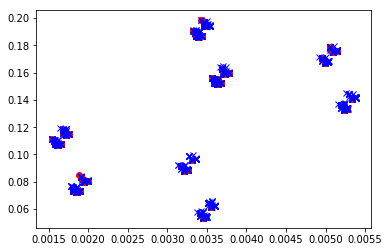

In [70]:
plt.plot(Am_X, Am_Y, 'ro', Non_X, Non_Y, 'bx')
#plt.show()
#plt.plot(Non_X, Non_Y, 'x')
plt.show()